## MonoForce Inference with ROUGH Data

We are going to load the ROUGH data and perform inference with the pretrained MonoForce model.

In [1]:
# add the path to the source code of the MonoForce package
import sys
sys.path.append('../src')

### Load the Terrain Encoder model

In [2]:
import torch
from monoforce.models.terrain_encoder.lss import LiftSplatShoot

def load_model(model_path):
    """
    Load the MonoForce model from a given path.
    :param model_path: str, path to the model
    :param robot: str, robot type
    :return: MonoForce model
    """
    lss_cfg_path = f'../config/lss_cfg.yaml'
    lss_cfg = read_yaml(lss_cfg_path)
    
    model = LiftSplatShoot(grid_conf=lss_cfg['grid_conf'], data_aug_conf=lss_cfg['data_aug_conf'])
    model.from_pretrained(model_path)
    model.eval()
    
    return model

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### Weights
The pretrained model weights could be downloaded from [Google Drive](https://drive.google.com/drive/folders/1n0KoUEQ0FIznf-qMKshk0C956CJenIhd?usp=drive_link)

In [3]:
from monoforce.utils import read_yaml

model_path = f'../config/weights/lss/lss.pt'
model = load_model(model_path)
# print(model)

Loaded pretrained weights for efficientnet-b0
Loading pretrained LiftSplatShoot model from ../config/weights/lss/lss.pt


In [4]:
import os
import numpy as np
from monoforce.datasets import ROUGH, rough_seq_paths
from monoforce.dphys_config import DPhysConfig

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def compile_data(seq_i=None, robot='tradr', small=False, is_train=False):
    """
    Compile the ROUGH dataset for a given sequence index and robot type.
    :param seq_i: int, sequence index
    :param robot: str, robot type
    :param small: bool, if True, return a small subset of the dataset
    :param is_train: bool, if True, return the training set, otherwise the test set
    :return: ROUGH dataset
    """
    dphys_cfg = DPhysConfig(robot=robot)

    lss_cfg_path = f'../config/lss_cfg.yaml'
    assert os.path.isfile(lss_cfg_path)
    lss_cfg = read_yaml(lss_cfg_path)

    if seq_i is not None:
        path = rough_seq_paths[seq_i]
    else:
        path = np.random.choice(rough_seq_paths)

    ds = ROUGH(path=path, dphys_cfg=dphys_cfg, lss_cfg=lss_cfg, is_train=is_train)
    if small:
        ds = ds[np.random.choice(len(ds), 4, replace=False)]

    return ds

In [6]:
robot = 'marv'
ds = compile_data(seq_i=1, robot=robot, small=False, is_train=False)
print(f"Number of samples: {len(ds)}")

Number of samples: 335


### Visualizing a sample from the dataset.

In [7]:
from monoforce.utils import position

i = np.random.choice(len(ds))
print(f"Sample index: {i}")
sample = ds[i]
points = torch.as_tensor(position(ds.get_cloud(i))).T
sample = sample + (points,)
(imgs, rots, trans, intrins, post_rots, post_trans,
 hm_geom, hm_terrain,
 control_ts, controls,
 pose0,
 traj_ts, Xs, Xds, Rs, Omegas, points) = sample
print(f"Images shape: {imgs.shape}")
print(f"Extrinsic Rotations shape: {rots.shape}")
print(f"Extrinsic Translations shape: {trans.shape}")
print(f"Intrinsic camera matrix shape: {intrins.shape}")
print(f"Images augmentation Post-rotation shape: {post_rots.shape}")
print(f"Images augmentation Post-translation shape: {post_trans.shape}")
print(f"Geometry heightmap shape: {hm_geom.shape}")
print(f"Heightmap terrain shape: {hm_terrain.shape}")
print(f"Control timestamps shape: {control_ts.shape}")
print(f"Controls shape: {controls.shape}")
print(f"Initial pose shape: {pose0.shape}")
print(f"Trajectory timestamps shape: {traj_ts.shape}")
print(f"Robot's positions shape: {Xs.shape}")
print(f"Robot's linear velocities shape: {Xds.shape}")
print(f"Robot's orientations shape: {Rs.shape}")
print(f"Robot's angular velocities shape: {Omegas.shape}")
print(f"Lidar points shape: {points.shape}")

Sample index: 234
Images shape: torch.Size([4, 3, 256, 416])
Extrinsic Rotations shape: torch.Size([4, 3, 3])
Extrinsic Translations shape: torch.Size([4, 3])
Intrinsic camera matrix shape: torch.Size([4, 3, 3])
Images augmentation Post-rotation shape: torch.Size([4, 3, 3])
Images augmentation Post-translation shape: torch.Size([4, 3])
Geometry heightmap shape: torch.Size([2, 128, 128])
Heightmap terrain shape: torch.Size([2, 128, 128])
Control timestamps shape: torch.Size([500])
Controls shape: torch.Size([500, 2])
Initial pose shape: torch.Size([4, 4])
Trajectory timestamps shape: torch.Size([5])
Robot's positions shape: torch.Size([5, 3])
Robot's linear velocities shape: torch.Size([5, 3])
Robot's orientations shape: torch.Size([5, 3, 3])
Robot's angular velocities shape: torch.Size([5, 3])
Lidar points shape: torch.Size([3, 131072])


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from monoforce.utils import explore_data

Loaded pretrained weights for efficientnet-b0
Selected data sample #38


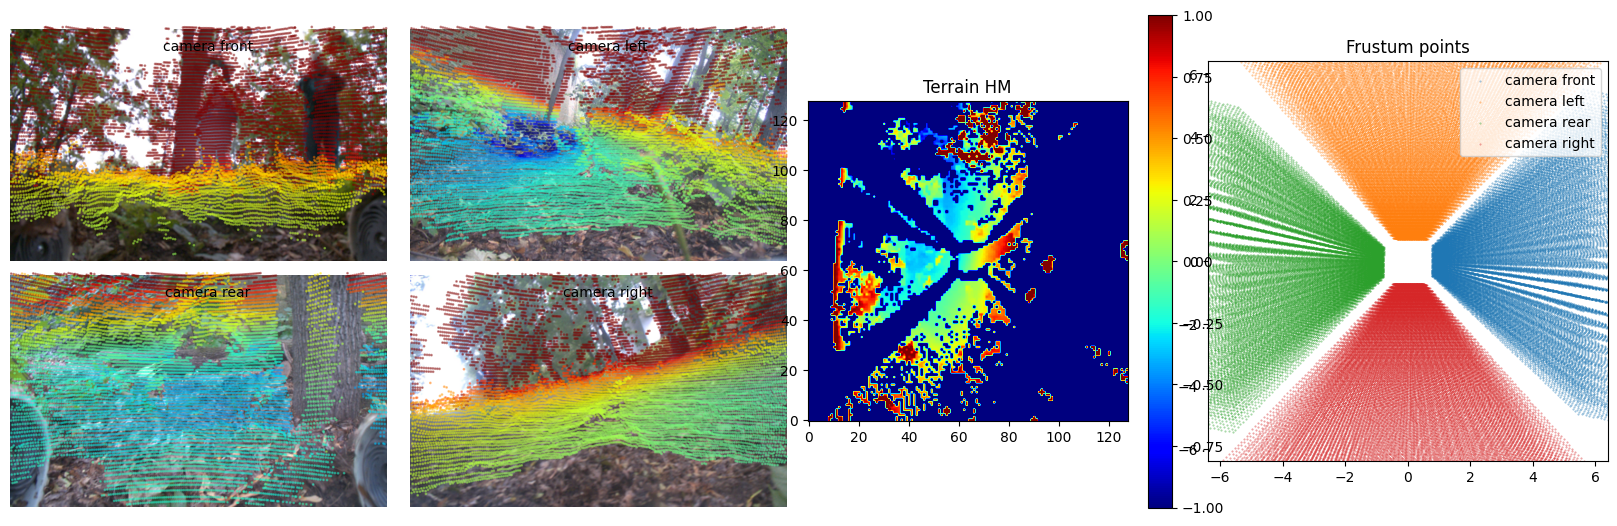

In [9]:
explore_data(ds)

### Inference with the MonoForce model

In [10]:
from timeit import default_timer as timer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

batch = [torch.as_tensor(s, device=device).unsqueeze(0) for s in sample]
(imgs, rots, trans, intrins, post_rots, post_trans,
 hm_geom, hm_terrain,
 control_ts, controls,
 pose0,
 traj_ts, Xs, Xds, Rs, Omegas,
 points) = batch

start = timer()
with torch.inference_mode():
    inputs = [imgs, rots, trans, intrins, post_rots, post_trans]
    out = model(*inputs)
end = timer()

heightmap_terrain = out['terrain']
friction = out['friction']
print(f"Heightmap terrain shape: {heightmap_terrain.shape}")
print(f"Friction shape: {friction.shape}")
print(f"Time taken for inference: {end - start} seconds")
print(f"Device: {list(model.parameters())[0].device}")

Heightmap terrain shape: torch.Size([1, 1, 128, 128])
Friction shape: torch.Size([1, 1, 128, 128])
Time taken for inference: 1.5711963540015859 seconds
Device: cuda:0


### Visualizing the predicted heightmap

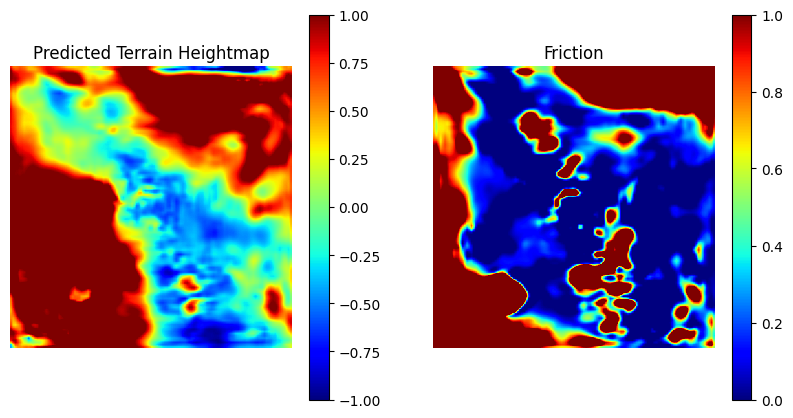

In [11]:
heightmap_terrain_np = heightmap_terrain.squeeze().cpu().numpy()
friction_np = friction.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(heightmap_terrain_np.T, origin='lower', cmap='jet', vmin=-1., vmax=1.)
plt.title('Predicted Terrain Heightmap')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(friction_np.T, origin='lower', cmap='jet', vmin=0, vmax=1)
plt.title('Friction')
plt.axis('off')
plt.colorbar()

plt.show()

## Predicting robot's trajectory with $\nabla$Physics

Control inputs could have the following format:
- Left and right velocity commands: $v_l = v_r = 1$ m/s
- Simulation time: $T = 5$ s
- Simulation step: $\Delta t = 0.01$ s

In [12]:
from monoforce.models.dphysics import DPhysics

dphys_cfg = DPhysConfig(robot=robot)
dphysics = DPhysics(dphys_cfg=dphys_cfg, device=device)

with torch.inference_mode():
    with torch.no_grad():
        states, forces = dphysics(z_grid=heightmap_terrain.squeeze(1), controls=controls)

In [13]:
Xs, Rs, Xds, Omegas = states
print(f"Robot's positions shape: {Xs.shape}")
print(f"Robot's orientation shape: {Rs.shape}")
print(f"Linear velocity shape: {Xds.shape}")
print(f"Angular velocity shape: {Omegas.shape}")

Robot's positions shape: torch.Size([1, 500, 3])
Robot's orientation shape: torch.Size([1, 500, 3])
Linear velocity shape: torch.Size([1, 500, 3, 3])
Angular velocity shape: torch.Size([1, 500, 3])


### Visualizing the robot's trajectory and heightmap

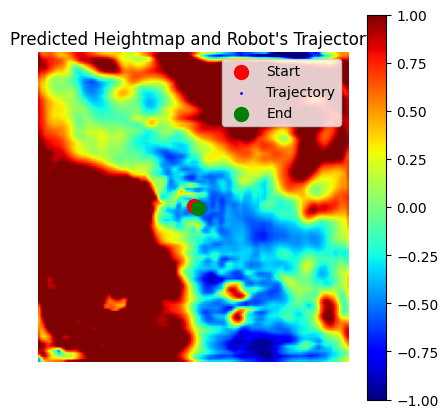

In [14]:
xs_grid = Xs.cpu().numpy()
xs_grid = xs_grid.reshape(-1, 3)
xs_grid = xs_grid[::10]  # downsample for visualization
xs_grid = (xs_grid[:, :2] + dphys_cfg.d_max) / dphys_cfg.grid_res  # normalize to grid resolution

for b in range(Xs.shape[0]):
    plt.figure(figsize=(5, 5))
    plt.imshow(heightmap_terrain_np.T, origin='lower', cmap='jet', vmin=-1., vmax=1.)
    plt.title('Predicted Heightmap and Robot\'s Trajectory')
    plt.axis('off')
    plt.colorbar()
    plt.scatter(xs_grid[0, 0], xs_grid[0, 1], c='red', s=100, label='Start')
    plt.scatter(xs_grid[:, 0], xs_grid[:, 1], c='blue', s=1, label='Trajectory')
    plt.scatter(xs_grid[-1, 0], xs_grid[-1, 1], c='green', s=100, label='End')
    plt.legend()
    plt.show()